In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict

### Hidden Markov Models (HMMs)
$$\begin{align*}P(O) &= \sum_Q P(O,Q)=\sum_Q P(O|Q)P(Q) \\ &= \sum_{j=1}^N \prod^T_{i=1}P(o_i|q_i)P(q_i|q_{i-1})= \sum_{j=1}^N \prod^T_{i=1}a_{ij}b(o_i)
\end{align*}$$
It is useful for 3 fundamental problems, 
1. Likelihood 
<p> Given an HMM $\lambda = (A,B)$ and an observation sequence $O$, determine the likelihood $P(O|\lambda)$. </p>
2. Decoding
<p> Given an observation sequence $O$ and and HMM $\lambda=(A,B)$, discover the best hidden state sequence Q. </p>
3. Learning
<p> Given an observation sequence $O$ and the set of states in the HMM, learn the HMM parameters $A$ and $B$. </p>

In [2]:
class HMM:
    def __init__(self):
        self.params = defaultdict(dict)
        self.o2id,self.id2o = dict(),dict()
        self.q2id,self.id2q = dict(),dict()
    def _setDistinctObservations(self,distO):
        self.o = len(distO)
        for i,o in enumerate(distO):
            self.o2id[o]=i
            self.id2o[i]=o
    def _setDistinctHiddens(self,distQ):
        self.q = len(distQ)
        A = np.random.uniform(0,1,(self.q,self.q))
        A /= np.sum(A,axis=1,keepdims=1)
        B = np.random.uniform(0,1,(self.q,self.o))
        B /= np.sum(B,axis=1,keepdims=1)
        pi = np.random.uniform(0,1,self.q)
        pi/= np.sum(pi)
        self.A = defaultdict(dict)
        self.B = defaultdict(dict)
        self.pi = {}
        for i,q in enumerate(distQ):
            self.q2id[q]=i
            self.id2q[i]=q
            for j,q_ in enumerate(distQ):
                self.A[i][j] = A[i][j]
            for k in range(self.o):
                self.B[i][k] = B[i][k]
            self.pi[i] = pi[i]
    def setDistinctHiddensAndObservations(self,distO,distQ):
        self._setDistinctObservations(distO)
        self._setDistinctHiddens(distQ)
    def setSpecificEmit(self,qSym,emitDict):
        assert sum(emitDict.values())==1, "Sum of probability is not 1"
        for i in self.B[self.q2id[qSym]].keys():
            # assert in dict
            self.B[self.q2id[qSym]][i]=emitDict.get(self.id2o[i],0)
        assert sum(self.B[self.q2id[qSym]].values())==1, "Sum of probability is not 1"
    def setSpecificTransit(self,qSym,tranDict):
        assert sum(tranDict.values())==1, "Sum of probability is not 1"
        for i in self.A[self.q2id[qSym]].keys():
            self.A[self.q2id[qSym]][i]=tranDict.get(self.id2q[i],0)
        assert sum(self.A[self.q2id[qSym]].values())==1, "Sum of probability is not 1"
    def setInitial(self,initDict):
        assert sum(initDict.values())==1, "Sum of probability is not 1"
        for i in self.pi.keys():
            # assert in dict
            self.pi[i]=initDict.get(self.id2q[i],0)
        assert sum(self.pi.values())==1, "Sum of probability is not 1"
    def computeLikelihood(self,Os):
        raise NotImplementedError("You need to implement function1 when you inherit from Model")
    def decode(self,Os):
        raise NotImplementedError("You need to implement function1 when you inherit from Model")
    def learn(self,Qs,Os):
        raise NotImplementedError("You need to implement function1 when you inherit from Model")

In [3]:
hmm = HMM()
hmm.setDistinctHiddensAndObservations([0,1,2,3],["H","C"])
hmm.setInitial({"H":0.7,"C":0.3})
hmm.setSpecificTransit("H",{"H":0.7,"C":0.3})
hmm.setSpecificTransit("C",{"H":0.8,"C":0.2})
hmm.setSpecificEmit("H",{0:0.2,1:0.7,2:0.05,3:0.05})
hmm.setSpecificEmit("C",{0:0.9,1:0.05,2:0.05})

#### 1. Likelihood: Forward Algorithm
a. Initialization
$$\alpha_1(j) = \pi_jb_j(o_1) \qquad 1\leq j\leq N$$
b. Recursion
$$\begin{align*}\alpha_t(j) &= P(\{o_i\}_{i=1}^t, q_t=j|\lambda) \\ 
&= \sum^N_{i=1}\alpha_{t-1}(i)a_{ij}b_j(o_t) \qquad 1\leq j\leq N\quad ,\quad 1<t\leq T \end{align*}$$
c. Termination
$$
P(O|\lambda) = \sum^N_{i=1}\alpha_T(i)
$$
<details>
<summary><h4>Click to view proof for Forward probability!</h4></summary>
$$\begin{align*}
\alpha_t(j) &= P(\{o_k\}^t_1,q_t=j|\lambda) = \sum^N_{i=1} P(\{o_k\}^{t-1}_1,o_t,q_t=j,q_{t-1}=i|\lambda)\\
&= \sum^N_{i=1}P(o_t|\{o_k\}^{t-1}_1,q_t=j,q_{t-1}=i,\lambda)P(q_t=j|\{o_k\}^{t-1}_1,q_{t-1}=i,\lambda) \\ &\qquad \times P(\{o_k\}^{t-1}_1,q_{t-1}=i|\lambda) \\
&= \sum^N_{i=1}P(\{o_k\}^{t-1}_1,q_{t-1}=i|\lambda)P(q_t=j|q_{t-1}=i,\lambda)P(o_t|q_t=j,\lambda) \\
&= \sum^N_{i=1}\alpha_{t-1}(i)a_{ij}b_j(o_t)
\end{align*}
$$
</details>

In [4]:
def likelihood(self,Os):
    Length = len(Os)
    alpha = np.zeros((self.q,Length))
    for t,o in enumerate(Os):
        for i in range(self.q):
            if t==0:
                alpha[i,t]=self.pi[i]*self.B[i][self.o2id[o]]
            else:
                for j in range(self.q):
                    alpha[i,t]+=alpha[j,t-1]*self.A[j][i]
                alpha[i,t]*=self.B[i][self.o2id[o]]
    return sum(alpha[:,-1]),alpha
    
hmm.computeLikelihood = lambda x:likelihood(hmm,x)

In [5]:
print(hmm.computeLikelihood([1]))
print(hmm.computeLikelihood([0]))
print(hmm.computeLikelihood([2]))
print(hmm.computeLikelihood([3]))
print(hmm.computeLikelihood([1,1]))
print(hmm.computeLikelihood([1,0]))
print(hmm.computeLikelihood([0,1]))
print(hmm.computeLikelihood([0,0]))

(0.5049999999999999, array([[0.49 ],
       [0.015]]))
(0.41000000000000003, array([[0.14],
       [0.27]]))
(0.049999999999999996, array([[0.035],
       [0.015]]))
(0.034999999999999996, array([[0.035],
       [0.   ]]))
(0.25599999999999995, array([[0.49  , 0.2485],
       [0.015 , 0.0075]]))
(0.20599999999999996, array([[0.49 , 0.071],
       [0.015, 0.135]]))
(0.2246, array([[0.14  , 0.2198],
       [0.27  , 0.0048]]))
(0.1492, array([[0.14  , 0.0628],
       [0.27  , 0.0864]]))


#### 2. Decoding: Viterbi Algorithm
a. Initialization
$$\begin{align*}
v_1(j) &= \pi_jb_j(o_1) &\qquad 1\leq j\leq N \\
bt_1(j) &= 0 &\qquad 1\leq j\leq N
\end{align*}
$$
b. Recursion
$$\begin{align*}
v_t(j) &=\max_{\{q_k\}_1^{t-1}} P(\{q_k\}_1^{t-1},\{o_k\}_1^t,q_t=j | \lambda) \\&= \max^N_{i=1}v_{t-1}(i)a_{ij}b_j(o_t) &\qquad 1\leq j\leq N\quad ,\quad 1<t\leq T\\
bt_t(j) &= \arg\max^N_{i=1}v_{t-1}(i)a_{ij}b_j(o_t) &\qquad 1\leq j\leq N\quad ,\quad 1<t\leq T\\
\end{align*}
$$
c. Termination
$$\begin{align*}
P* &= \max^N_{i=1}v_T(i) \\
q_T* &= \arg\max^N_{i=1}v_T(i)
\end{align*}
$$

In [6]:
def decode(self,Os):
    Length = len(Os)
    V = np.zeros((self.q,Length))
    bt = [0]*Length
    for t,o in enumerate(Os):
        for i in range(self.q):
            if t==0:
                V[i,t]=self.pi[i]*self.B[i][self.o2id[o]]
            else:
                for j in range(self.q):
                    V[i,t]=max(V[i,t],V[j,t-1]*self.A[j][i])
                V[i,t]*=self.B[i][self.o2id[o]]
        bt[t]=self.id2q[np.argmax(V[:,t])]
    P_ = max(V[:,-1])
    return P_,bt
hmm.decode = lambda x:decode(hmm,x)

In [7]:
for o in hmm.o2id.keys():
    print(hmm.decode([o]))

(0.27, ['C'])
(0.48999999999999994, ['H'])
(0.034999999999999996, ['H'])
(0.034999999999999996, ['H'])


In [8]:
hmm.decode([0,0,0,0])

(0.0020995200000000006, ['C', 'C', 'C', 'C'])

#### 3. Learning: HMM Training with Forward-Backward Algorithm
> Backward Probability

a. Initialization
$$\beta_T(i) = 1 \qquad 1\leq i\leq N$$
b. Recursion
$$\begin{align*}
\beta_t(i) &= P(\{o_k\}_{t+1}^T|q_t=i,\lambda) \\
&=\sum^N_{j=1}a_{ij}b_j(o_{t+1})\beta_{t+1}(j) \qquad 1\leq i\leq N\quad,\quad 1\leq t<T
\end{align*}
$$
c. Termination
$$P(O|\lambda)=\sum^N_{j=1}\pi_j b_j(o_1)\beta_1(j)$$
<details >
<summary><h4>Click to view proof for Backward probability!</h4></summary>
$$\begin{align*}
\beta_t(i) &= P(\{o_k\}_{t+1}^T|q_t=i,\lambda) = \sum^N_{j=1}P(q_{t+1}=j,o_{t+1},\{o_k\}^T_{t+2}|q_t=i,\lambda) \\
&= \sum^N_{j=1}\frac{P(q_{t+1}=j,o_{t+1},\{o_k\}^T_{t+2},q_t=i|\lambda)}{P(q_t=i|\lambda)} \\
&= \sum^N_{j=1}\frac{P(o_{t+1}|q_{t+1}=j,\{o_k\}^T_{t+2},q_t=i,\lambda)\times\\P(\{o_k\}^T_{t+2}|q_{t+1}=j,q_t=i,\lambda)\times\\P(q_{t+1}=j|q_t=i,\lambda)P(q_t=i|\lambda)}{P(q_t=i|\lambda)} \\
&= \sum^N_{j=1}P(q_{t+1}=j|q_t=i,\lambda)P(o_{t+1}|q_{t+1}=j,\lambda)P(\{o_k\}^T_{t+2}|q_{t+1}=j,\lambda) \\
&= \sum^N_{j=1}a_{ij}b_j(o_{t+1})\beta_{t+1}(j)
\end{align*}$$
</details>



In [9]:
def likelihood_backwards(self,Os):
    Length = len(Os)
    beta = np.zeros((self.q,Length))
    for t in range(Length-1,-1,-1):
        o = Os[t]
        for i in range(self.q):
            if t==Length-1:
                beta[i,t]=1
            else:
                for j in range(self.q):
                    o_tp1 = self.o2id[Os[t+1]]
                    tmp=beta[j,t+1]*self.A[i][j]
                    tmp*=self.B[j][o_tp1]
                    beta[i,t]+=tmp

    P = 0
    for j in range(self.q):
        P+=self.pi[j]*self.B[j][self.o2id[Os[0]]]*beta[j,0]
    return P,beta
    
hmm.likelihood_backwards = lambda x:likelihood_backwards(hmm,x)
               

In [10]:
print(hmm.computeLikelihood([1])[0],
      hmm.likelihood_backwards([1])[0])
print(hmm.computeLikelihood([0])[0],
      hmm.likelihood_backwards([0])[0])
print(hmm.computeLikelihood([2])[0],
      hmm.likelihood_backwards([2])[0])
print(hmm.computeLikelihood([3])[0],
      hmm.likelihood_backwards([3])[0])
print(hmm.computeLikelihood([1,1])[0],
      hmm.likelihood_backwards([1,1])[0])
print(hmm.computeLikelihood([1,0])[0],
      hmm.likelihood_backwards([1,0])[0])
print(hmm.computeLikelihood([0,1])[0],
      hmm.likelihood_backwards([0,1])[0])
print(hmm.computeLikelihood([0,0])[0],
      hmm.likelihood_backwards([0,0])[0])

0.5049999999999999 0.5049999999999999
0.41000000000000003 0.41000000000000003
0.049999999999999996 0.049999999999999996
0.034999999999999996 0.034999999999999996
0.25599999999999995 0.2559999999999999
0.20599999999999996 0.206
0.2246 0.22459999999999997
0.1492 0.14920000000000003


#### Sampling from HMM

In [11]:
def samples(self,length):
    Qs,Os = [],[]
    for i in range(length):
        if i==0:
            q = np.random.choice(self.q,1,
                    p=list(self.pi.values()))
        else:
            q = np.random.choice(self.q,1,
                    p=list(self.A[q[0]].values()))
        o = np.random.choice(self.o,1,
                    p=list(self.B[q[0]].values()))
        Qs.append(self.id2q[q[0]])
        Os.append(self.id2o[o[0]])
    return Qs,Os

hmm.samples = lambda x:samples(hmm,x)

In [12]:
N = 10
for i in range(N):
    Qs,Os = hmm.samples(6)
    l,alpha = hmm.computeLikelihood(Os)
    lB,beta = hmm.likelihood_backwards(Os)
    lQ,dQs = hmm.decode(Os)
    print(Qs,dQs,lQ,Os,l,lB)

['C', 'C', 'H', 'C', 'H', 'H'] ['C', 'C', 'C', 'C', 'H', 'H'] 0.000576108288 [0, 0, 0, 0, 1, 1] 0.00559189888 0.005591898879999998
['H', 'H', 'C', 'H', 'H', 'C'] ['H', 'H', 'C', 'H', 'H', 'C'] 0.004802902775999997 [1, 1, 0, 1, 1, 0] 0.011813907699999994 0.011813907699999992
['C', 'C', 'H', 'H', 'C', 'H'] ['H', 'C', 'H', 'C', 'C', 'H'] 0.000144027072 [2, 0, 1, 0, 0, 1] 0.0008563935100000001 0.0008563935099999997
['H', 'C', 'H', 'H', 'H', 'H'] ['H', 'C', 'H', 'H', 'H', 'C'] 0.0003430644839999998 [1, 0, 1, 2, 1, 0] 0.0012072514999999996 0.0012072514999999999
['H', 'H', 'H', 'C', 'H', 'H'] ['C', 'H', 'H', 'C', 'H', 'H'] 0.005489031743999998 [0, 1, 1, 0, 1, 1] 0.012865923699999999 0.012865923699999993
['C', 'H', 'H', 'H', 'H', 'C'] ['C', 'H', 'C', 'H', 'H', 'C'] 1.5431472e-05 [0, 1, 0, 3, 2, 0] 6.8314235e-05 6.831423500000002e-05
['H', 'H', 'H', 'H', 'C', 'H'] ['H', 'H', 'C', 'H', 'C', 'C'] 0.00012602368800000003 [3, 1, 0, 1, 0, 0] 0.00058717435 0.0005871743500000001
['H', 'H', 'H', 'C', 'C

> Transition Probability Matrix $A$

$$\begin{align*}
    \hat{a}_{ij}&=\frac{\sum^{T-1}_{t=1}\xi_t(i,j)}{\sum^{T-1}_{t=1}\sum^N_{k=1}\xi_t(i,k)}\\
    \xi_t(i,j) &= \frac{\alpha_t(i)a_{ij}b_j(o_{t+1})\beta_{t+1}(j)}{\sum^N_{j=1}\alpha_t(j)\beta_t(j)}
\end{align*}$$
<details >
<summary><h4>Click to view proof for transition probability!</h4></summary>

</details>

> Emission Probabilities $B$

$$\begin{align*}
\hat{b}_j(v_k) &= \frac{\sum^T_{t=1 s.t.O_t=v_k}\gamma_t(j)}{\sum^T_{t=1}\gamma_t(j)} \\
\gamma_t(j) &= \frac{\alpha_t(j)\beta_t(j)}{\sum^N_{j=1}\alpha_t(j)\beta_t(j)}
\end{align*}$$
<details >
<summary><h4>Click to view proof for emission probability!</h4></summary>

</details>

In [13]:
def e_step(self,Os):
    Length = len(Os)
    l,alpha = self.computeLikelihood(Os)
    lB,beta = self.likelihood_backwards(Os)
    alphabeta = alpha*beta
    sum_alphabeta = np.sum(alphabeta,axis=0)
    gamma = alphabeta/sum_alphabeta
    xi = np.zeros((Length,self.q,self.q))
    for t in range(Length-1):
        o_tp1 = self.o2id[Os[t+1]]
        for i in range(self.q):
            for j in range(self.q):
                tmp=alpha[i,t]*beta[j,t+1]
                tmp*=self.A[i][j]*self.B[j][o_tp1]
                xi[t,i,j]=tmp/sum_alphabeta[t]
    return l,gamma,xi

In [14]:
def m_step(self,Os,gamma,xi):
    atop = np.sum(xi[:-1,:,:],axis=0)
    abottom = np.sum(atop,axis=1,keepdims=1)
    Os = np.array(Os)
    btop = np.zeros((self.o,self.q))
    for o in range(self.o):
        tmp = gamma[:,Os==self.id2o[o]].sum(axis=1)
        btop[o,:] = tmp
    bbottom = gamma.sum(axis=1)
    return atop,abottom,btop,bbottom

In [15]:
def update(self,A,B,pi):
    for i in range(self.q):
        for j in range(self.q):
            self.A[i][j]=A[i,j]
        self.pi[i]=pi[i]
        for o in range(self.o):
            self.B[i][o]=B[o,i]

In [16]:
def learn(self,Osamples,iters=10):
    ls = []
    for _ in tqdm(range(iters)):
        tmp,at,ab,bt,bb,pt = 0,0,0,0,0,0
        for Os in Osamples:
            l,gamma,xi = self.e_step(Os)
            tmp+=l
            atop,abottom,btop,bbottom = self.m_step(Os,gamma,xi)
            at+=atop
            ab+=abottom
            bt+=btop
            bb+=bbottom
            pt+=gamma[:,0]
        ls.append(tmp/N)
        pi = pt/N
        A = at/ab
        B = bt/bb
        self.update(A,B,pi)
    return ls

In [17]:
def add_patch(obj):
    obj.computeLikelihood = lambda x:likelihood(obj,x)
    obj.decode = lambda x:decode(obj,x)
    obj.likelihood_backwards = lambda x:likelihood_backwards(obj,x)
    obj.samples = lambda x:samples(obj,x)
    obj.e_step = lambda x:e_step(obj,x)
    obj.m_step = lambda x,y,z: m_step(obj,x,y,z)  
    obj.update = lambda x,y,z: update(obj,x,y,z)
    obj.learn = lambda x,y: learn(obj,x,y)
    return obj

In [18]:
hmm = add_patch(hmm)
N,T = 1000,6
Osamples = []
for _ in range(N):
    Qs,Os = hmm.samples(T)
    Osamples.append(Os)

In [19]:
print(Osamples[0:3])

[[1, 1, 0, 0, 2, 1], [0, 1, 1, 1, 0, 2], [3, 0, 1, 1, 0, 1]]


In [20]:
model = HMM()
model.setDistinctHiddensAndObservations([0,1,2,3],["H","C"])
model = add_patch(model)

In [21]:
print(model.A)
print(model.B)
print(model.pi)

defaultdict(<class 'dict'>, {0: {0: 0.27598362460892506, 1: 0.724016375391075}, 1: {0: 0.5013706614085423, 1: 0.49862933859145786}})
defaultdict(<class 'dict'>, {0: {0: 0.5443808888985004, 1: 0.3033362788273822, 2: 0.12024252800943273, 3: 0.032040304264684634}, 1: {0: 0.2990199978975486, 1: 0.5255697653609589, 2: 0.13800031157842993, 3: 0.03740992516306255}})
{0: 0.8155274069343782, 1: 0.18447259306562178}


100%|██████████| 10/10 [00:00<00:00, 11.12it/s]


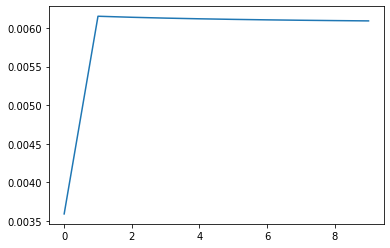

In [22]:
iters = 10
ls = model.learn(Osamples,iters)
plt.plot(range(iters),ls)

In [23]:
print(model.A)
print(model.B)
print(model.pi)

defaultdict(<class 'dict'>, {0: {0: 0.2776440717125321, 1: 0.7223559282874671}, 1: {0: 0.5129663961349196, 1: 0.4870336038650777}})
defaultdict(<class 'dict'>, {0: {0: 0.5028424147483609, 1: 0.40213675664317416, 2: 0.05541431048363899, 3: 0.0396065181248238}, 1: {0: 0.31566145542028834, 1: 0.6035400248517026, 2: 0.046014210209111756, 3: 0.03478430951889797}})
{0: 0.7423630004191993, 1: 0.25763699958080183}


In [24]:
print(hmm.A)
print(hmm.B)
print(hmm.pi)

defaultdict(<class 'dict'>, {0: {0: 0.7, 1: 0.3}, 1: {0: 0.8, 1: 0.2}})
defaultdict(<class 'dict'>, {0: {0: 0.2, 1: 0.7, 2: 0.05, 3: 0.05}, 1: {0: 0.9, 1: 0.05, 2: 0.05, 3: 0}})
{0: 0.7, 1: 0.3}


### References
- https://web.stanford.edu/~jurafsky/slp3/A.pdf
- https://en.wikipedia.org/wiki/Baum%E2%80%93Welch_algorithm